In [60]:
import numpy as np
import pandas as pd
import csv
import struct
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.font_manager import FontProperties
import matplotlib.ticker as tkr
import warnings
warnings.simplefilter('ignore')
%config InlineBackend.figure_format = 'svg'
# %config InlineBackend.figure_format = 'jpg'
matplotlib.rcParams.update({'font.size':14})
%matplotlib inline

from datetime import datetime, timedelta
import tensorflow as tf
from tensorflow import keras
import statistics as sts

from keras import Sequential
from keras.layers import Dense
from keras.optimizers import RMSprop, Adam
from keras import layers
from keras import regularizers
from sklearn.model_selection import train_test_split
from keras.models import Sequential, model_from_json
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint

from sklearn.preprocessing import LabelEncoder, StandardScaler, scale
from sklearn.decomposition import PCA

from numba import vectorize
from numba import njit

In [10]:
# reading and additional functions

# define moving average function
def moving_avg(x, n):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[n:] - cumsum[:-n]) / float(n)

# check exist date in roti date array
def exist_date_roti(roti_date, date_check):
    for date_r in roti_date:
        if date_check[0] == date_r[0] and date_check[1] == date_r[1] and date_check[2] == date_r[2]:
            return True
    return False

# mean data
def mean_data(data, train_num=3935):
    mean = data[:train_num].mean(axis=0)
    data -= mean
    std = data[:train_num].std(axis=0)
    data /= std
    return data

# convert doy in normal date with day and month
def doy2day(doy, year):
    startDate = datetime(year=year, month=1, day=1)
    daysToShift = doy - 1
    endDate = startDate + timedelta(days=daysToShift)
    
    month = endDate.month
    day = endDate.day
    
    return day, month

def day2doy(date):
    day = date[0]
    month = date[1]
    year = date[2]
    months = [0, 31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334]

    if 0 < month and month <= 12:
        sum = months[month - 1]
    else:
        print("month error")

    sum += day
    leap = 0

    if year % 400 == 0 or (year % 4 == 0 and year % 100 != 0):
        leap = 1

    if leap == 1 and month > 2:
        sum += 1
    
    return sum

def read_roti(filename):
    with open(filename, 'rb') as f:
        header_read = False
        date = None
        lats = []
        rows = []
        date_arr = []
        line = f.readline()
        while not header_read or (line.strip() and not line.strip().startswith(b"END OF ROTIPOLARMAP")):
            if line.strip().startswith(b"START OF ROTIPOLARMAP"):
                header_read = True
            elif line.strip().startswith(b"END OF ROTIPOLARMAP") or line.strip().startswith(b"END OF FILE"):
                break
            elif not header_read:
                pass
            elif line[0:5].strip():
                date = datetime(int(line[0:7]), int(line[7:14]), int(line[14:21]))
                year = int(line[0:7])
                month = int(line[7:14])
                day = int(line[14:21])
                
                date_arr.append(day)
                date_arr.append(month)
                date_arr.append(year)
            else:
                lat, lon_start, lon_end = float(line[3:9]), float(line[9:15]), float(line[15:21])
                lats.append(lat)

                block = [f.readline() for _ in range(18)]
                row = np.genfromtxt(block)
                rows.append(row.ravel())
            line = f.readline()
        return date, np.array(lats), np.array(date_arr), np.array(rows)

def get_array_roti():
    maps = []
    map_date = []
    for year in range(10, 23, 1):
        for doy in range(1, 367, 1):
            if doy >= 295 and year == 20:
                continue
            daily_lats = []
            daily_date = []
            daily_map = []
            
            if len(str(doy)) == 1:
                doy_str = "00" + str(doy)
            elif len(str(doy)) == 2:
                doy_str = "0" + str(doy)
            else:
                doy_str = str(doy)
            filename = '../data/roti/2010-2020/roti' + doy_str + '0.' + str(year) + 'f'
            try:
                date, daily_lats, daily_date, daily_map = read_roti(filename)
            except FileNotFoundError:
                continue
            else:
                date, daily_lats, daily_date, daily_map = read_roti(filename)

            map_date.append(daily_date)
            maps.append(daily_map)

    return np.array(map_date), np.array(maps)

def read_dst(filename, roti_date):
    with open(filename, 'r') as f:
        dst_arr = []
        dst_mean_arr = []
        dst_date = []

        day = 0
        month = 0
        year = 0

        while day != 21 or month != 10 or year != 2020:
            dst_daily = []
            date = []

            line = f.readline()

            year = int(2000 + int(line[3:5]))
            month = int(line[5:7])
            day = int(line[8:10])
                
            date.append(day)
            date.append(month)
            date.append(year)
            
            if not exist_date_roti(roti_date, date):
                continue

            dst_date.append(date)

            if len(line) > 121:
                index_string = line[21:len(line)]
            else:
                index_string = line[21:120]

            index_value = index_string.split()
            for value in index_value:
                val = float(value)
                dst_daily.append(val)

            dst_mean = dst_daily[-1]
            dst_daily.pop(-1)
            dst_arr.append(dst_daily)
            dst_mean_arr.append(dst_mean)
        
        return np.array(dst_arr), np.array(dst_date), np.array(dst_mean_arr)

def add_special_date_f107(day, month, year, f107_arr, f107_date):
    f107_daily = []
    date = []
    if year == 2011:
        value = 90.1
    elif year == 2012:
        value = 131.75
    elif year == 2015:
        value = 148.8
    elif year == 2020:
        value = 72.93
    f107_daily.append(value)
    f107_arr.append(f107_daily)
    date.append(day)
    date.append(month)
    date.append(year)
    f107_date.append(date)
    return f107_arr, f107_date

def read_f107(filename, roti_date):
    with open(filename, 'rb') as f:
        f107_arr = []
        f107_date = []
        day = 0
        month = 0
        year = 0
        
        # we should skip 2 lines in file bc it is head of file
        line = f.readline()
        line = f.readline()

        start_indx = 0
        sum_siblings = 0
        f107_obs_sum = 0

        while day != 22 or month != 10 or year != 2020:
            f107_daily = []
            date = []
            
            line = f.readline()
            
            year = int(line[0:4])
            month = int(line[4:6])
            day = int(line[6:8])
            
            if year < 2009 or month < 12 or day < 4:
                continue
            
            date.append(day)
            date.append(month)
            date.append(year)

            if not exist_date_roti(roti_date, date):
                continue

            if start_indx == 0:
                start_date = date
                start_indx = 1

            f107_obs = float(line[53:63])

            if start_date[0] != date[0] or start_date[1] != date[1] or start_date[2] != date[2]:
                f107_date.append(start_date)
                if sum_siblings == 1:
                    value = f107_obs_sum / 2
                elif sum_siblings == 2:
                    value = f107_obs_sum / 3
                elif sum_siblings == 3:
                    value = f107_obs_sum / 4
                else:
                    value = f107_obs
                f107_daily.append(value)
                f107_arr.append(f107_daily)
                sum_siblings = 0
                f107_obs_sum = 0
                if start_date[0] == 31 and start_date[1] == 12 and start_date[2] == 2010:
                    f107_arr, f107_date = add_special_date_f107(1, 1, 2011, f107_arr, f107_date)
                if start_date[0] == 31 and start_date[1] == 12 and start_date[2] == 2011:
                    f107_arr, f107_date = add_special_date_f107(1, 1, 2012, f107_arr, f107_date)
                if start_date[0] == 12 and start_date[1] == 1 and start_date[2] == 2015:
                    f107_arr, f107_date = add_special_date_f107(13, 1, 2015, f107_arr, f107_date)
                if start_date[0] == 20 and start_date[1] == 10 and start_date[2] == 2020:
                    f107_arr, f107_date = add_special_date_f107(21, 10, 2020, f107_arr, f107_date)
                start_date = date
            else:
                f107_obs_sum += f107_obs
                sum_siblings += 1

        return np.array(f107_arr), np.array(f107_date)

def read_bz_sw(filename, roti_date):
    with open(filename, 'rb') as f:
        bz_arr = []
        bz_date = []
        sw_arr = []
        sw_date = []
        
        day = 0
        month = 0
        year = 0
        
        while day != 21 or month != 10 or year != 2020:
            bz_daily = []
            sw_daily = []
            date = []
            
            line = f.readline()
            
            year = int(line[0:4])
            doy = int(line[5:8])
            day, month = doy2day(doy, year)
            
            date.append(day)
            date.append(month)
            date.append(year)

            if not exist_date_roti(roti_date, date):
                continue
            
            bz_sw_string = line[18:len(line)]
            bz_sw_value = bz_sw_string.split()
            
            bz_date.append(date)
            sw_date.append(date)
            
            for i in range(3):
                if i == 0:
                    bz_daily.append(float(bz_sw_value[i].decode()))
                else:
                    sw_daily.append(float(bz_sw_value[i].decode()))
            
            bz_arr.append(bz_daily)
            sw_arr.append(sw_daily)
        
    return np.array(bz_arr), np.array(bz_date), np.array(sw_arr), np.array(sw_date)

def read_kp(filename, roti_date):
    with open(filename, 'rb') as f:
        kp_arr = []
        kp_date = []
        
        day = 0
        month = 0
        year = 0

        # we should skip first line in file bc it is head of file
        line = f.readline()
        
        while day != 21 or month != 10 or year != 2020:
            kp_daily = []
            date = []

            line = f.readline()

            year = int(line[0:4])
            month = int(line[4:6])
            day = int(line[6:8])

            date.append(day)
            date.append(month)
            date.append(year)

            if not exist_date_roti(roti_date, date):
                continue

            kp_date.append(date)

            kp_str = str(line[25:28].decode())
            
            if kp_str[len(kp_str) - 1] == '+':
                kp_value = float(kp_str[:len(kp_str) - 1]) + 1/3
                kp_value = float("{0:.2f}".format(kp_value))
            elif kp_str[len(kp_str) - 1] == '-':
                kp_value = float(kp_str[:len(kp_str) - 1]) - 1/3
                kp_value = float("{0:.2f}".format(kp_value))
            else:
                kp_value = float(kp_str)

            kp_daily.append(kp_value)
            kp_arr.append(kp_daily)
            
        return np.array(kp_arr), np.array(kp_date)


- scalar B (IMF) - average 24 hour (1 value)    
- BZ - average 24 hour (1 value)    
- BZ - min 24 hour (1 value)    
- F10-7 - average 24 hour (1 value)     
- F10-7 - 27-days (27 previous days) median (1 value)
- AL - average 24 hour (1 value)    
- AU - average 24 hour (1 value)    
- date (1 value)    

index | name
:----: | ------------
0 | avg scalar B
1 | avg BZ
2 | avg F10-7
3 | avg AL
4 | avg AU
5 | min BZ
6 | F10-7 27-days median
7-12 | indexes 0-5 27 days ago

In [3]:
# read data function

def read_all_data(filename, roti_date, day_end, month_end, year_end):
    with open(filename, 'rb') as f:
        all_data_arr = []
        date_arr = []
        
        day = 0
        month = 0
        year = 0
        
        while day != day_end or month != month_end or year != year_end:
            all_data_daily = []
            data_daily = []
            date = []
            
            line = f.readline()
            
            year = int(line[0:4])
            doy = int(line[5:8])
            day, month = doy2day(doy, year)
            
            date.append(day)
            date.append(month)
            date.append(year)

            if not exist_date_roti(roti_date, date) and year >= 2010:
                continue
            
            for _ in range(23):
                all_data_hour = []
                data_string = line[13:len(line)]
                data_values = data_string.split()
                for i in range(5):
                    all_data_hour.append(float(data_values[i].decode()))
                all_data_daily.append(all_data_hour)
                line = f.readline()

            all_data_daily = np.array(all_data_daily)
            data_min = all_data_daily.min(axis=0)
            data_max = all_data_daily.max(axis=0)
            data_means = np.mean(all_data_daily, axis=0)
            # add average values
            for i in range(len(data_means)):
                data_daily.append(data_means[i])
            # add max B scalar
            data_daily.append(data_max[0])
            # add min bz
            data_daily.append(data_min[1])
            all_data_arr.append(data_daily)
            date_arr.append(date)

    return np.array(all_data_arr), np.array(date_arr)

def median_f107(all_data, start_indx):
    all_median = []

    for index in range(start_indx, len(all_data), 1):
        median = []
        for i in range(index - 26, index + 1, 1):
            median.append(all_data[i][2])
        median = sorted(median)
        all_median.append(median[14])
    return np.array(all_median)
    
def get_all_data(filename, train_roti_maps, roti_map_date, day_end, month_end, year_end):
    all_data, date_arr = read_all_data(filename, roti_map_date, day_end, month_end, year_end)
    data_all_arr = []
    all_date_arr = []

    start_indx = 0
    for i in range(len(date_arr)):
        if date_arr[i][0] == 1 and date_arr[i][1] == 1 and date_arr[i][2] == 2010:
            start_indx = i
            break
    f107_median = median_f107(all_data, start_indx)
    
    for i in range(start_indx, len(all_data) - 1, 1):
        data_daily = []
        # for j in range(6):
        #     data_daily.append(all_data[i][j])
        # data_daily.append(f107_median[i - 31])
        # for j in range(6):
        #     data_daily.append(all_data[i - 26][j])

        # avg F10-7
        data_daily.append(all_data[i][2])
        data_daily.append(f107_median[i - start_indx])
        data_daily.append(all_data[i - 27][2])
        # max scalar B
        data_daily.append(all_data[i][5])
        # max scalar B 27 days ago
        data_daily.append(all_data[i - 27][5])
        # min BZ
        data_daily.append(all_data[i][6])
        data_daily.append(all_data[i + 1][6])
        data_daily.append(all_data[i - 27][6])
        for j in range(len(train_roti_maps[i - start_indx])):
            data_daily.append(train_roti_maps[i - start_indx][j])
        all_date_arr.append(date_arr[i])
        data_all_arr.append(data_daily)

    return np.array(data_all_arr), np.array(all_date_arr)


index | name
:----: | ------------
0 | avg F10-7
1 | F10-7 27-days median
2 | avg F10-7 27 days ago
3 | max scalar B
4 | max scalar B 27 days ago
5 | min BZ
6 | min BZ 27 days ago
7 | min BZ next day
8 | avg ROTI in the whole map

In [4]:
# plotting functions

def plot_data_roti(date, lons, lats, map):
    lons, lats = np.meshgrid(lons, lats)

    fig1 = plt.figure()
    ax = fig1.add_subplot(111, projection='polar')
    levels = np.arange(0, 0.6, 0.1)
    cc = ax.contourf(np.deg2rad(lons), 90. - lats, map, levels=levels, extend='both')

    plt.title("ROTI index date: " + str(date))

    plt.colorbar(cc, ax=ax, label="ROTI, TECU/min")

    mlt = np.linspace(0, 24, 49)

    plt.show()

def plot_sw_index(date, array_data, name_index):
    fig_prot = plt.figure()
    ax_prot = fig_prot.add_subplot(111)

    fig_pls = plt.figure()
    ax_pls = fig_pls.add_subplot(111)

    prot = []
    pls = []

    data_month_prot = []
    data_month_pls = []
    month_line_prot = []
    month_line_pls = []

    if name_index == 'Solar Wind':
        for item in array_data:
            prot.append(item[0])
            pls.append(item[1])

    day_line = np.arange(0, len(date), 1).reshape(len(array_data), 1)

    for i in range(len(array_data)):
        if i % 30 == 0:
            data_month_prot.append(np.mean(prot[i - 30: i]))
            data_month_pls.append(np.mean(pls[i - 30: i]))
            month_line_prot.append(i - 30 / 2)
            month_line_pls.append(i - 30 / 2)

    data_avg_prot = moving_avg(prot, 400)
    data_avg_plasm = moving_avg(pls, 400)
    data_avg_prot.reshape(len(data_avg_prot), 1)
    data_avg_plasm.reshape(len(data_avg_plasm), 1)
    step = len(prot) / len(data_avg_prot)
    day_avg = np.arange(0, len(date), step).reshape(len(data_avg_prot), 1)

    ax_pls.set_title('Data index Plasma Speed, km/s')
    ax_pls.set_xlabel('Days', size=12)
    ax_pls.set_ylabel(name_index, size=12)
    # ax.plot(day_line, array_data, label='Day')
    ax_pls.plot(month_line_pls, data_month_pls, label='Month')
    ax_pls.plot(day_avg, data_avg_plasm, color='red', label='Avg-400')
    # ax.plot(half_year_line, data_half_year, color='black', label='Half-year')
    ax_pls.legend(loc='upper left')

    ax_prot.set_title('Data index Proton Density, N/cm^3')
    ax_prot.set_ylim(0, 20)
    ax_prot.set_xlabel('Days', size=12)
    ax_prot.set_ylabel(name_index, size=12)
    # ax.plot(day_line, array_data, label='Day')
    ax_prot.plot(month_line_prot, data_month_prot, label='Month')
    ax_prot.plot(day_avg, data_avg_prot, color='red', label='Avg-400')
    # ax.plot(half_year_line, data_half_year, color='black', label='Half-year')
    ax_prot.legend(loc='upper left')

    plt.show()

def plot_data_index(date, array_data, name_index):
    fig = plt.figure()
    ax = fig.add_subplot(111)

    pdf = PdfPages("../images/ROTI-graph.pdf")

    data_month = []
    month_line = []

    data_half_year = []
    half_year_line = []

    data_year = []
    year_line = []

    day_line = np.arange(0, len(date), 1).reshape(len(array_data), 1)

    for i in range(len(array_data)):
        if i % 30 == 0:
            data_month.append(np.mean(array_data[i - 30: i]))
            month_line.append(i - 30 / 2)

    for i in range(len(array_data)):
        if i % 180 == 0:
            data_half_year.append(np.mean(array_data[i - 180: i]))
            half_year_line.append(i - 180 / 2)
    
    data_avg = moving_avg(array_data, 365)
    data_avg.reshape(len(data_avg), 1)
    step = len(array_data) / len(data_avg)
    day_avg = np.arange(0, len(date), step).reshape(len(data_avg), 1)

    # ax.set_title('Data index ' + name_index)
    # ax.set_xlabel('Days', size=12)
    # ax.set_ylabel(name_index, size=12)
    ax.set_xlabel('Days')
    ax.set_ylabel(name_index)

    match name_index:
        case 'Flux 10-7':
            ax.plot(month_line, data_month, label='Month')
            ax.plot(half_year_line, data_half_year, label='Half-year')
            ax.plot(day_avg, data_avg, color='red', label='Avg-400')
            # ax.plot(year_line, data_year, color='black', label='Year')
            ax.legend(loc='upper left')
        case 'Imf-Bz':
            # ax.plot(day_line, array_data, label='Day')
            ax.plot(month_line, data_month, label='Month')
            ax.plot(day_avg, data_avg, color='red', label='Avg-400')
            # ax.plot(half_year_line, data_half_year, color='black', label='Half-year')
            ax.legend(loc='upper left')
        case _:
            ax.plot(day_line, array_data, label='Per day')
            ax.plot(month_line, data_month, label='Per month')
            ax.plot(day_avg, data_avg, color='red', label='Per year')
            # ax.plot(half_year_line, data_half_year, color='black', label='Half-year')
            ax.legend(fontsize = 12, loc='upper right')
    pdf.savefig(fig)
    pdf.close()
    plt.show()

def plot_new_data_index(date, data, name_index, index):
    fig = plt.figure()
    ax = fig.add_subplot(111)

    data_month = []
    month_line = []

    data_half_year = []
    half_year_line = []

    data_year = []
    year_line = []

    array_data = []

    for i in range(len(data)):
        array_data.append(data[i][index])
    array_data = np.array(array_data)

    day_line = np.arange(0, len(date), 1).reshape(len(array_data), 1)

    for i in range(len(array_data)):
        if i % 30 == 0:
            data_month.append(np.mean(array_data[i - 30: i]))
            month_line.append(i - 30 / 2)

    for i in range(len(array_data)):
        if i % 180 == 0:
            data_half_year.append(np.mean(array_data[i - 180: i]))
            half_year_line.append(i - 180 / 2)
    
    data_avg = moving_avg(array_data, 400)
    data_avg.reshape(len(data_avg), 1)
    step = len(array_data) / len(data_avg)
    day_avg = np.arange(0, len(date), step).reshape(len(data_avg), 1)

    ax.set_title('Data index ' + name_index)
    ax.set_xlabel('Days', size=12)
    ax.set_ylabel(name_index, size=12)

    match name_index:
        case 'average BZ':
            ax.set_ylim(-0.2, 0.3)
            ax.plot(month_line, data_month, label='Month')
            ax.plot(half_year_line, data_half_year, label='Half-year')
            ax.plot(day_avg, data_avg, color='red', label='Avg-400')
            # ax.plot(year_line, data_year, color='black', label='Year')
            ax.legend(loc='upper left')
        case 'average F10-7':
            # ax.set_ylim(0, 60)
            # ax.plot(day_line, array_data, label='Day')
            ax.plot(month_line, data_month, label='Month')
            ax.plot(day_avg, data_avg, color='red', label='Avg-400')
            ax.plot(half_year_line, data_half_year, color='orange', label='Half-year')
            ax.legend(loc='upper left')
        case 'median F10-7':
            # ax.set_ylim(0, 60)
            ax.plot(day_line, array_data, label='Day')
            # ax.plot(month_line, data_month, label='Month')
            ax.plot(day_avg, data_avg, color='red', label='Avg-400')
            # ax.plot(half_year_line, data_half_year, color='orange', label='Half-year')
            ax.legend(loc='upper left')
        case _:
            ax.plot(day_line, array_data, label='Day')
            ax.plot(month_line, data_month, label='Month')
            ax.plot(day_avg, data_avg, color='red', label='Avg-400')
            # ax.plot(half_year_line, data_half_year, color='black', label='Half-year')
            ax.legend(loc='upper left')
    plt.show()

In [5]:
# roti data and date
roti_map_date = []
roti_maps = []
roti_map_date, roti_maps = get_array_roti()

# filename = "../data/roti/rt_data_10-20.txt"
# date, lats, roti_map_date, roti_maps = read_roti_txt(filename)
roti_maps_reshape = roti_maps.reshape(roti_maps.shape[0], 3600)
print("shape roti data ", roti_maps.shape)
print("shape roti data reshape", roti_maps_reshape.shape)
print("shape roti date line ", roti_map_date.shape)
# roti_map_date

shape roti data  (4469, 20, 180)
shape roti data reshape (4469, 3600)
shape roti date line  (4469, 3)


In [6]:
def roti_encode(roti_maps, less_num):
    new_roti_maps = []
    for i in range(len(roti_maps)):
        j = 0
        new_roti_map = []
        while j < len(roti_maps[i]):
            numbers_roti = []
            for item in range(less_num):
                numbers_roti.append(roti_maps[i][j + item])
            j += less_num
            numbers_roti = np.array(numbers_roti)
            new_roti_map.append(np.mean(numbers_roti))
        new_roti_maps.append(new_roti_map)
    return np.array(new_roti_maps)

def roti_decode(roti_maps, less_num):
    new_roti_maps = []
    for i in range(len(roti_maps)):
        j = 0
        new_roti_map = []
        while j < len(roti_maps[i]):
            for num in range(less_num):
                new_roti_map.append(roti_maps[i][j])
            j += 1
        new_roti_maps.append(new_roti_map)
    return np.array(new_roti_maps)

new_roti_maps = roti_encode(roti_maps_reshape, 5)
train_roti_maps = roti_encode(roti_maps_reshape, 3600)
print(new_roti_maps.shape)
print(train_roti_maps.shape)

(4469, 720)
(4469, 1)


index | name
:----: | ------------
0 | avg F10-7
1 | F10-7 27-days median
2 | avg F10-7 27 days ago
3 | max scalar B
4 | max scalar B 27 days ago
5 | min BZ
6 | min BZ 27 days ago
7 | min BZ next day
8 | avg ROTI in the whole map

In [7]:
# filename = "../data/imf-bz-f107-au-al/omni2_1C8cy8n9vH.lst.txt"
filename = "../data/imf-bz-f107-au-al/omni2_Shvf6pN7UL.lst.txt"
data_all_arr, date_arr = get_all_data(filename, train_roti_maps, roti_map_date, day_end=19, month_end=6, year_end=2022)
print(data_all_arr.shape)
print(date_arr.shape)
# for i in range(3):
#     print(data_all_arr[i])

(4468, 9)
(4468, 3)


In [8]:
print("ROTI date start", roti_map_date[0])
print("ROTI date end", roti_map_date[-1], "\n")

print("Indexes date start", date_arr[0])
print("Indexes date end", date_arr[-1])

ROTI date start [   1    1 2010]
ROTI date end [  19    6 2022] 

Indexes date start [   1    1 2010]
Indexes date end [  18    6 2022]


### Principal Component Analysis (PCA)

Now let's choose the number of components that we will use for further work. To do this, let's look at the ratio of variance and the number of components that explain it for all these indices

There are several reasons why dimensionality reduction is used in machine learning: to combat computational costs, to control retraining, as well as to visualize and help interpret high-dimensional datasets.

Often in machine learning, the more features there are in a dataset, the better the classifier can be trained. However, more functions also means higher computational costs. Not only can high dimensionality lead to a long learning time, a larger number of functions often leads to retooling of the algorithm as it tries to create a model that explains all the functions in the data.

Since reducing the dimensionality reduces the total number of features, this can reduce the computational requirements associated with training the model, but also helps to combat overfitting by keeping the features that will be transferred to the model fairly simple.

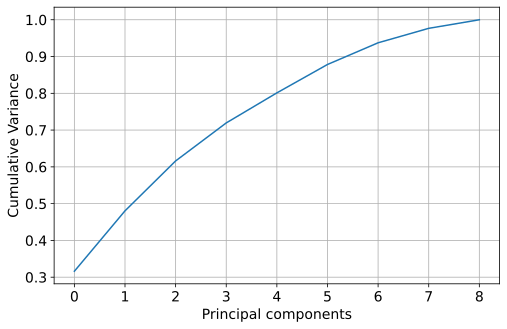

In [25]:
# Normalize data
train_num = len(data_all_arr)

def mean_data(data):
    mean = data[:train_num].mean(axis=0)
    data -= mean
    std = data[:train_num].std(axis=0)
    data /= std
    return data

all_indexes = mean_data(data_all_arr)

pdf = PdfPages("../images/pca.pdf")

font = FontProperties() 
font.set_family('serif') 
font.set_name('Times New Roman') 
font.set_size(16)

scaler = StandardScaler()
X_features = scaler.fit_transform(all_indexes)

pca = PCA(n_components=all_indexes.shape[-1])
pca.fit(X_features)
pca_variance = pca.explained_variance_

var1 = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4))

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(var1)
ax.set_ylabel("Cumulative Variance")
ax.set_xlabel("Principal components")
plt.grid()
pdf.savefig(fig)
pdf.close()
plt.show()

Now we will use PCA to get a list of functions and plot which functions have the greatest explanatory power or have the greatest variance. These are the main components.

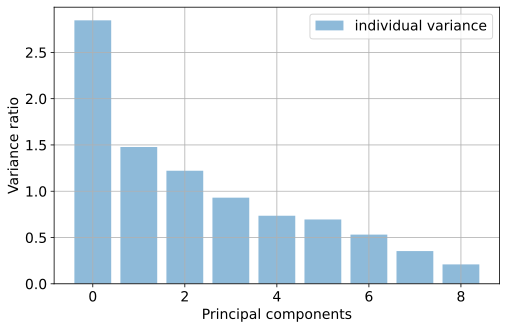

In [24]:
pdf = PdfPages("../images/pca_bar.pdf")
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(range(9), pca_variance, alpha=0.5, align='center', label='individual variance')
ax.set_ylabel("Variance ratio")
ax.set_xlabel("Principal components")
plt.grid()
plt.legend()
pdf.savefig(fig)
pdf.close()
plt.show()

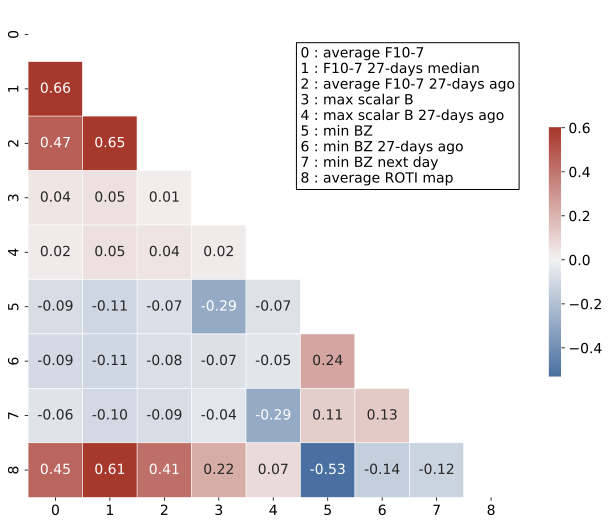

In [26]:
import seaborn as sns

df = pd.DataFrame(all_indexes, columns = ['0', '1', '2', '3', '4', '5', '6', '7', '8'])

# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(250, 15, s=75, l=40,
                            n=9, center="light", as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
fig = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.6, center=0, annot=True, 
            fmt='.2f', square=True, linewidths=.5, cbar_kws={"shrink": .5})
text = "0 : average F10-7\n1 : F10-7 27-days median\n2 : average F10-7 27-days ago\n3 : max scalar B\n4 : max scalar B 27-days ago\n5 : min BZ\n6 : min BZ 27-days ago\n7 : min BZ next day\n8 : average ROTI map"
plt.text(5., 2., text, fontsize=14,
 # Vertical and horizontal alignment
 horizontalalignment='left', verticalalignment='center',
 bbox=dict(facecolor='white', alpha=1.0))

plt.show()

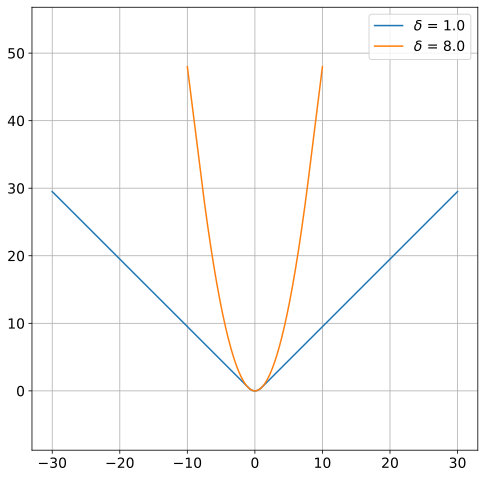

In [98]:
# Huber function plot
def huber_func(x, delta=8.0):
    if abs(x) <= delta:
        answer = 0.5 * pow(x, 2)
    else:
        answer = delta * (abs(x) - 0.5 * delta)
    return answer

pdf = PdfPages("../images/huber-func.pdf")
x1 = np.linspace(-30., 30., 10000)
x = np.linspace(-10., 10., 10000)
y1 = [huber_func(item, delta=1.0) for item in x1]
y2 = [huber_func(item, delta=8.0) for item in x]
fig, ax = plt.subplots(figsize=(8, 8))
ax.axis('equal')
ax.plot(x1, y1, label="$\delta$ = 1.0")
ax.plot(x, y2, label="$\delta$ = 8.0")
plt.grid()
plt.legend()
pdf.savefig(fig)
pdf.close()
plt.show()

In [99]:
filename = "../data/imf-bz-f107-au-al/omni2_Shvf6pN7UL.lst.txt"
data_all_arr, date_arr = get_all_data(filename, train_roti_maps, roti_map_date, day_end=19, month_end=6, year_end=2022)

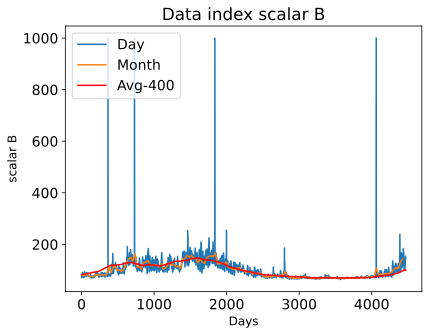

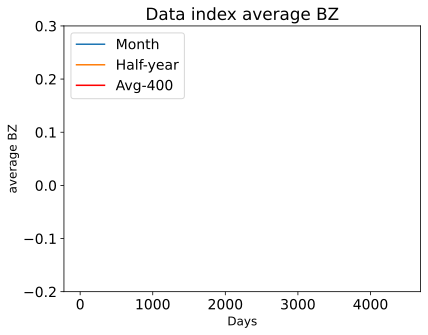

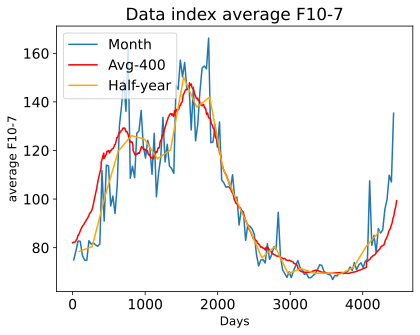

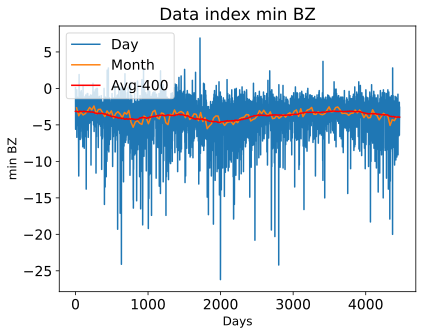

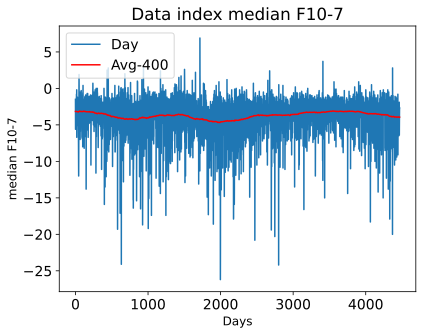

In [100]:
plot_new_data_index(date_arr, data_all_arr, 'scalar B', 0)
plot_new_data_index(date_arr, data_all_arr, 'average BZ', 1)
plot_new_data_index(date_arr, data_all_arr, 'average F10-7', 2)
plot_new_data_index(date_arr, data_all_arr, 'min BZ', 5)
plot_new_data_index(date_arr, data_all_arr, 'median F10-7', 6)

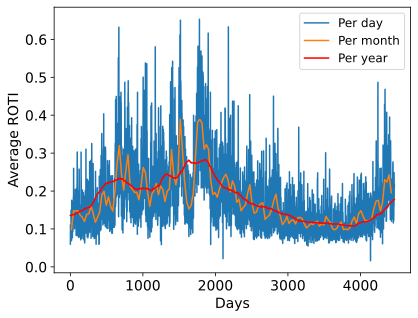

In [113]:
def plot_roti_graph(roti_maps_reshape, roti_map_date):
    average_roti = []
    for i in range(len(roti_maps_reshape)):
        avg = sts.mean(roti_maps_reshape[i])
        average_roti.append(avg)

    average_roti = np.array(average_roti)
    plot_data_index(roti_map_date, average_roti, 'Average ROTI')

plot_roti_graph(roti_maps_reshape, roti_map_date)

In [19]:
def average_roti_classification(roti_maps_reshape):
    # data roti
    roti_class = []
    # data dst
    for i in range(len(roti_maps_reshape)):
        roti_class.append(sts.mean(roti_maps_reshape[i]))
    avr_num = sts.mean(roti_class)
    less_count = 0
    more_count = 0
    roti_class = np.array(roti_class)
    for i in range(len(roti_maps_reshape)):
        if roti_class[i] <= avr_num:
            less_count += 1
        else:
            more_count += 1
    delta = less_count - more_count
    percent = delta / less_count * 100
    return avr_num, less_count, more_count, delta, percent

def data_make_roti_classification(roti_maps_reshape, all_indexes):
    avr_num, less_count, more_count, delta, percent = average_roti_classification(roti_maps_reshape)
    print("average ROTI", avr_num)
    roti_class = []
    for i in range(len(roti_maps_reshape)):
        if sts.mean(roti_maps_reshape[i]) < avr_num:
            roti_class.append(0)
        else:
            roti_class.append(1)
    return np.array(roti_class)
    
# print(average_roti_classification(roti_maps_reshape))
roti_class = data_make_roti_classification(roti_maps_reshape, all_indexes)

average ROTI 0.17716703560950747


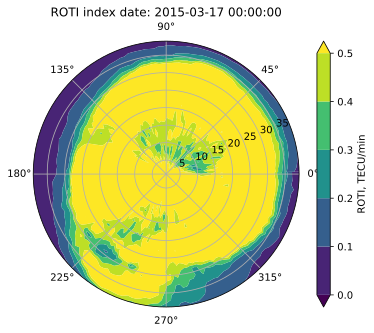

1899


In [21]:
doy = ["076"]
all_maps = []

for day in doy:
    filename = '../data/roti/2010-2020/roti' + day + '0.15f'

    lats = []
    rows = []
    date_map = []

    date, lats, date_map, map = read_roti(filename)

    all_maps.append(map)
    all_map = np.mean(all_maps, axis=0)
    lons = np.linspace(1, 361, all_map.shape[1])
    plot_data_roti(date, lons, lats, map)

for i in range(len(roti_map_date)):
    if roti_map_date[i][0] == 15 and roti_map_date[i][1] == 3 and roti_map_date[i][2] == 2015:
        print(i)
        break

In [11]:
# Normalize data

train_num = 3100
all_indexes = mean_data(data_all_arr)
print(all_indexes.shape)

(4468, 9)


In [50]:
# https://habr.com/ru/post/495884/
all_indexes = mean_data(data_all_arr)

start_index = 0
end_index = 3100
end_index_val = 3935
# end_index = 9000
history_size = 2
target_size = 1
batch_size = 24
buffer_size = 256

def multivariate_data(all_indexes, new_roti_maps, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  forbidden_indx = [1897, 1898, 1899, 1900, 1901, 1994, 1995, 1996, 1997, 1998, 1999, 2000]

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(all_indexes) - target_size

  for i in range(start_index, end_index):
    if i in forbidden_indx:
      continue
    indices = range(i - history_size, i, 1)
    data.append(all_indexes[indices])
    labels.append(new_roti_maps[i + target_size - 1])

  return np.array(data), np.array(labels)

def multivariate_data_test(all_indexes, new_roti_maps, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(all_indexes) - target_size

  for i in range(start_index, end_index):
    indices = range(i - history_size, i, 1)
    data.append(all_indexes[indices])
    labels.append(new_roti_maps[i + target_size - 1])

  return np.array(data), np.array(labels)

x_train, y_train = multivariate_data(all_indexes, new_roti_maps, start_index, end_index, history_size, target_size)
x_train_test, y_train_test = multivariate_data_test(all_indexes, new_roti_maps, 0, None, history_size, target_size)
# x_train, y_train = multivariate_data(big_indexes, big_roti, start_index, end_index, history_size, target_size)
# x_train = x_train.reshape(x_train.shape[0], x_train.shape[1] * x_train.shape[2])
# x_train_test = x_train_test.reshape(x_train_test.shape[0], x_train_test.shape[1] * x_train_test.shape[2])

x_val, y_val = multivariate_data(all_indexes, new_roti_maps, end_index, end_index_val, history_size, target_size)
# x_val, y_val = multivariate_data(big_indexes, big_roti, end_index, end_index_val, history_size, target_size)
# x_val = x_val.reshape(x_val.shape[0], x_val.shape[1] * x_val.shape[2])

train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.cache().shuffle(buffer_size).batch(batch_size).repeat()
# train_data = train_data.batch(batch_size).repeat()

val_data = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_data = val_data.batch(batch_size).repeat()

In [51]:
print(x_train.shape)
print(x_train_test.shape)
print(x_val.shape)

(3086, 2, 9)
(4465, 2, 9)
(833, 2, 9)


```
    shuffle(buffer_size, seed=None, reshuffle_each_iteration=None, name=None)
```

Randomly shuffles the elements of this dataset.

This dataset fills a buffer with buffer_size elements, then randomly samples elements from this buffer, replacing the selected elements with new elements. For perfect shuffling, a buffer size greater than or equal to the full size of the dataset is required.

For instance, if your dataset contains 10,000 elements but buffer_size is set to 1,000, then shuffle will initially select a random element from only the first 1,000 elements in the buffer. Once an element is selected, its space in the buffer is replaced by the next (i.e. 1,001-st) element, maintaining the 1,000 element buffer.

In [89]:
from keras import metrics

weights_file = 'W_NN_ts.h5'

callback = ModelCheckpoint(weights_file, mode='max', save_best_only=True)

classifier = Sequential()
classifier.add(layers.LSTM(10, input_shape=x_train.shape[-2:]))
classifier.add(Dense(512, activation='relu', kernel_initializer='random_normal'))
classifier.add(Dense(1024, activation='relu', kernel_initializer='random_normal'))
classifier.add(Dense(812, activation='relu', kernel_initializer='random_normal'))
classifier.add(Dense(720, activation='sigmoid', kernel_initializer='random_normal'))

classifier.compile(optimizer='adam', loss=tf.keras.losses.Huber(delta=8.0), metrics=['accuracy'])

classifier.summary()

history = classifier.fit(
    train_data,
    epochs=80,
    steps_per_epoch=x_train.shape[0] // batch_size,
    validation_data=val_data,
    validation_steps=x_val.shape[0] // batch_size,
    callbacks=[callback])

json_file = 'M_NN_ts.json'
model_json = classifier.to_json()
with open(json_file, 'w') as f:
    f.write(model_json)

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_19 (LSTM)              (None, 10)                800       
                                                                 
 dense_76 (Dense)            (None, 512)               5632      
                                                                 
 dense_77 (Dense)            (None, 1024)              525312    
                                                                 
 dense_78 (Dense)            (None, 812)               832300    
                                                                 
 dense_79 (Dense)            (None, 720)               585360    
                                                                 
Total params: 1,949,404
Trainable params: 1,949,404
Non-trainable params: 0
_________________________________________________________________
Epoch 1/80
128/128 [=======================

In [13]:
# for loaded models
# model_file = 'M_NN_ts.json'
# weights_file = 'W_NN_ts.h5'
# with open(model_file, 'r') as f:
#   loaded_model = model_from_json(f.read())
   
# loaded_model.load_weights(weights_file)
# loaded_model.summary()

In [19]:
import pydot
import pydotplus
tf.keras.utils.plot_model(classifier, to_file="../images/my_model.pdf", show_shapes=True)

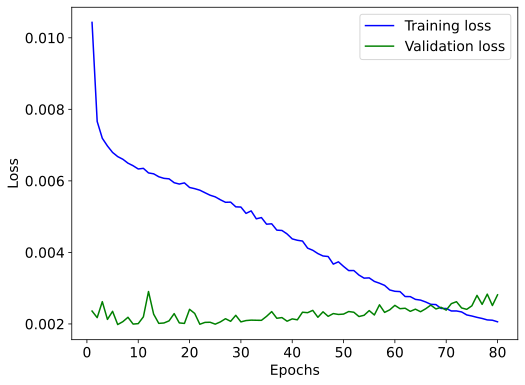

In [90]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

pdf = PdfPages("../images/loss.pdf")
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(epochs, loss, 'b', label='Training loss')
ax.plot(epochs, val_loss, 'g', label='Validation loss')
ax.set_ylabel("Loss")
ax.set_xlabel("Epochs")
plt.legend()
pdf.savefig(fig)
pdf.close()
plt.show()

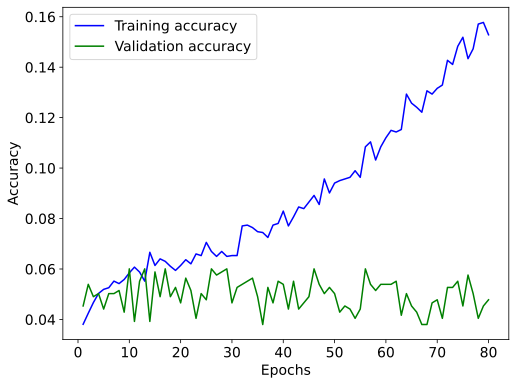

In [91]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(loss) + 1)

pdf = PdfPages("../images/acc.pdf")
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(epochs, accuracy, 'b', label='Training accuracy')
ax.plot(epochs, val_accuracy, 'g', label='Validation accuracy')
ax.set_ylabel("Accuracy")
ax.set_xlabel("Epochs")
plt.legend()
pdf.savefig(fig)
pdf.close()
plt.show()

In [33]:
def plot_roti_near(date, lons, lats, map, pred_map):
    lons, lats = np.meshgrid(lons, lats)

    fig, axs = plt.subplots(nrows=1 , ncols=2, figsize=(15, 5))
    [axi.set_axis_off() for axi in axs.ravel()]

    for ax in axs:
        date_str = str(date)
        date_str = date_str[:-9]
        ax = fig.add_subplot(121, projection='polar')
        levels = np.arange(0, 0.6, 0.1)
        cc = ax.contourf(np.deg2rad(lons), 90. - lats, map, levels=levels, extend='both')
        ax.set_title("ROTI date: " + date_str, fontsize=18)
        fig.colorbar(cc, ax=ax, label="ROTI, TECU/min", location='left')
        mlt = np.linspace(0, 24, 49)

        ax = fig.add_subplot(122, projection='polar')
        levels = np.arange(0, 0.6, 0.1)
        cc = ax.contourf(np.deg2rad(lons), 90. - lats, pred_map, levels=levels, extend='both')
        ax.set_title("Prediction ROTI date: " + date_str, fontsize=18)
        fig.colorbar(cc, ax=ax, label="ROTI, TECU/min", location='right')
        mlt = np.linspace(0, 24, 49)
    
    plt.show()

def plot_roti_near_file(date, lons, lats, map, pred_map, pdf_file):
    lons, lats = np.meshgrid(lons, lats)

    pdf = PdfPages(pdf_file)
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    [axi.set_axis_off() for axi in axs.ravel()]
   
    date_str = str(date)
    date_str = date_str[:-9]
    axs[0] = fig.add_subplot(121, projection='polar')
    levels = np.arange(0, 0.6, 0.1)
    cc = axs[0].contourf(np.deg2rad(lons), 90. - lats, map, levels=levels, extend='both')
    axs[0].set_title("ROTI date: " + date_str, fontsize=18)
    mlt = np.linspace(0, 24, 49)
    # plt.colorbar(cc, ax=ax1, label="ROTI, TECU/min")
    fig.colorbar(cc, ax=axs[0], label="ROTI, TECU/min", location='left')
    
    axs[1] = fig.add_subplot(122, projection='polar')
    levels = np.arange(0, 0.6, 0.1)
    cc = axs[1].contourf(np.deg2rad(lons), 90. - lats, pred_map, levels=levels, extend='both')
    axs[1].set_title("Prediction ROTI date: " + date_str, fontsize=18)
    mlt = np.linspace(0, 24, 49)
    fig.colorbar(cc, ax=axs[1], label="ROTI, TECU/min", location='right')
    
    pdf.savefig(fig)
    pdf.close()
    plt.show()

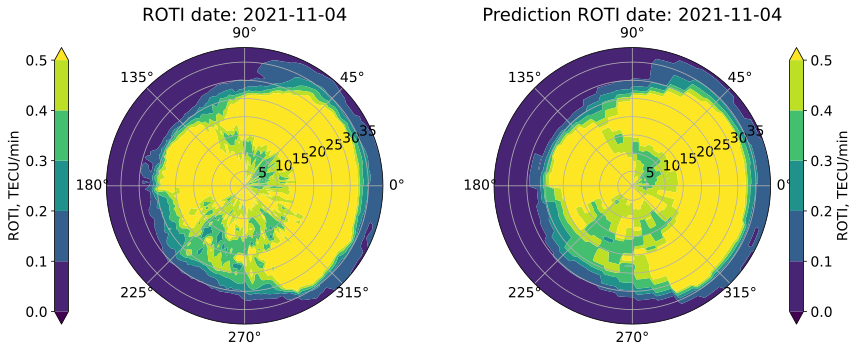

In [47]:
pdf_file = "../images/compare-roti.pdf"

start = 4241
end = start + 1

for i in range(start, end, 1):
    # doy = str(day2doy(roti_map_date[i]) + x_train.shape[-1] // 6)
    doy = str(day2doy(roti_map_date[i]))
    # doy = str(day2doy(roti_map_date[i]) + 1)
    year = str(roti_map_date[i][2] - 2000)
    if len(doy) == 1:
        filename = '../data/roti/2010-2020/roti' + '00' + doy + '0.' + year + 'f'
    elif len(doy) == 2:
        filename = '../data/roti/2010-2020/roti' + '0' + doy + '0.' + year + 'f'
    else:
        filename = '../data/roti/2010-2020/roti' + doy + '0.' + year + 'f'
    lats = []
    rows = []
    date_map = []
    all_maps = []

    pred_map = []
    for j in range(new_roti_maps.shape[-1]):
        pred_map.append(new_roti_maps[start][j])
    pred_map = np.array(pred_map)
    pred_map = pred_map.reshape(1, pred_map.shape[-1])

    date, lats, date_map, map = read_roti(filename)

    all_maps.append(map)
    all_map = np.mean(all_maps, axis=0)
    lons = np.linspace(1, 361, all_map.shape[1])
    pred_map = roti_decode(pred_map, less_num=5)
    pred_map = pred_map.reshape(20, 180)
    plot_roti_near_file(date, lons, lats, map, pred_map, pdf_file)

1/1 [==============================] - 0s 10ms/step
(1, 720)


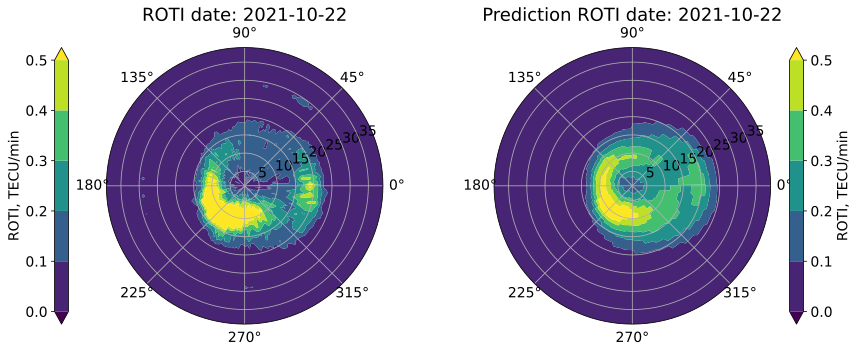

In [43]:
pdf_file = "../images/nonchalant_result.pdf"
# start = 1996
start = 4226
end = start + 1

y_pred=classifier.predict(x_train_test[start:end])

print(y_pred.shape)

for i in range(start, end, 1):
    # doy = str(day2doy(roti_map_date[i]) + x_train.shape[-1] // 6)
    doy = str(day2doy(roti_map_date[i]) + x_train_test.shape[1])
    # doy = str(day2doy(roti_map_date[i]) + 1)
    year = str(roti_map_date[i][2] - 2000)
    if len(doy) == 1:
        filename = '../data/roti/2010-2020/roti' + '00' + doy + '0.' + year + 'f'
    elif len(doy) == 2:
        filename = '../data/roti/2010-2020/roti' + '0' + doy + '0.' + year + 'f'
    else:
        filename = '../data/roti/2010-2020/roti' + doy + '0.' + year + 'f'
    lats = []
    rows = []
    date_map = []
    all_maps = []

    pred_map = []
    for j in range(y_pred.shape[-1]):
        pred_map.append(y_pred[i - start][j])
    pred_map = np.array(pred_map)
    pred_map = pred_map.reshape(1, pred_map.shape[-1])

    date, lats, date_map, map = read_roti(filename)

    all_maps.append(map)
    all_map = np.mean(all_maps, axis=0)
    lons = np.linspace(1, 361, all_map.shape[1])
    pred_map = roti_decode(pred_map, less_num=5)
    pred_map = pred_map.reshape(20, 180)
    plot_roti_near_file(date, lons, lats, map, pred_map, pdf_file)

1/1 [==============================] - 0s 13ms/step
(5, 720)


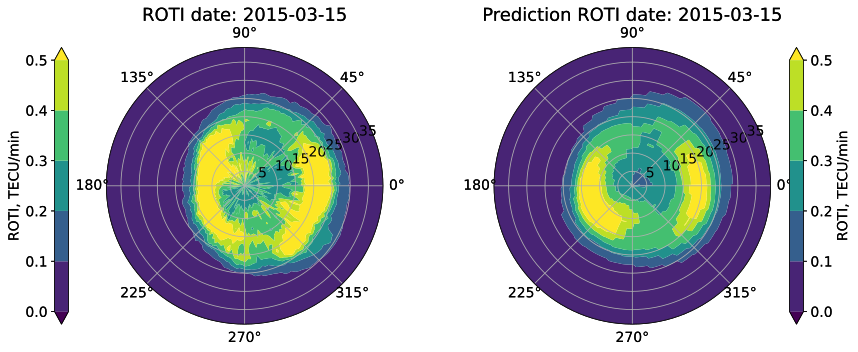

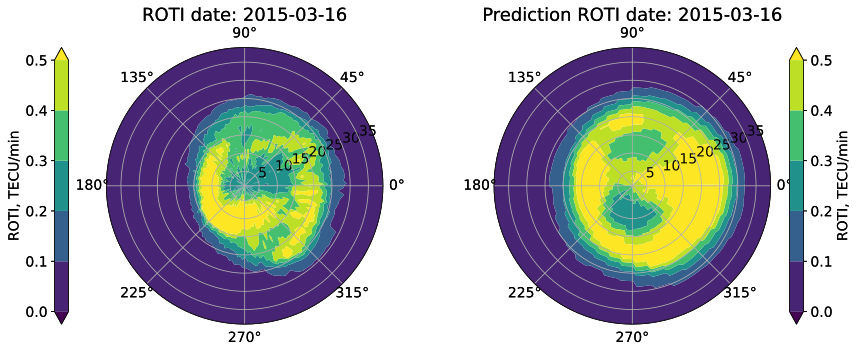

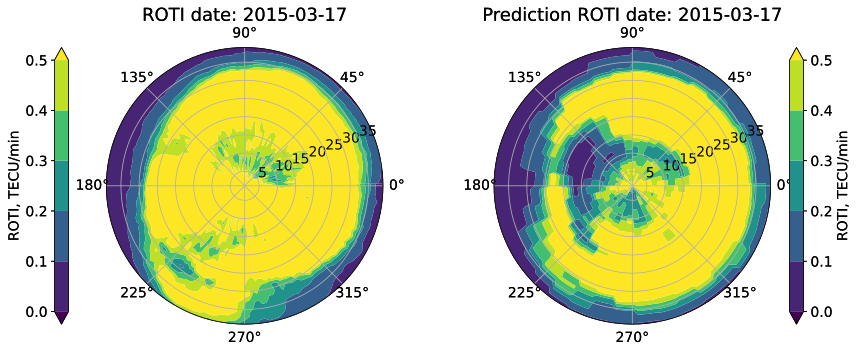

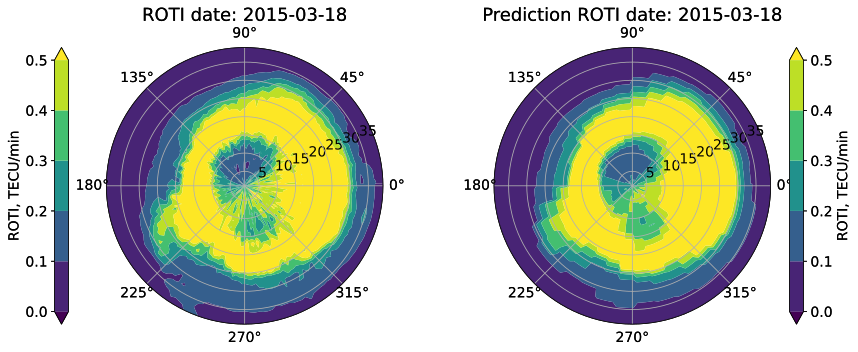

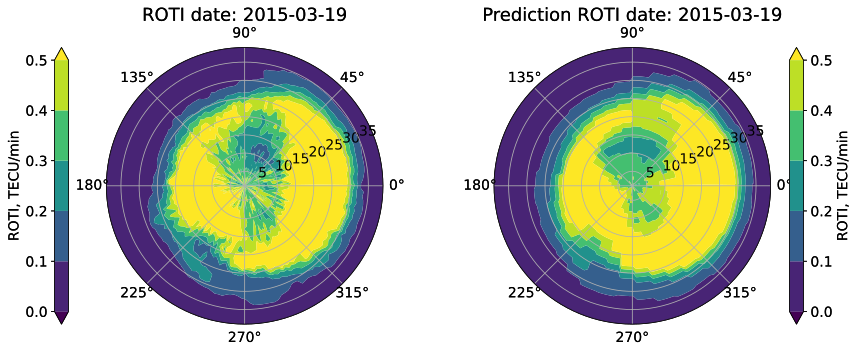

In [19]:
start = 1897
end = 1902

y_pred=classifier.predict(x_train_test[start:end])

print(y_pred.shape)

for i in range(start, end, 1):
    # doy = str(day2doy(roti_map_date[i]) + x_train.shape[-1] // 6)
    doy = str(day2doy(roti_map_date[i]) + x_train_test.shape[1])
    # doy = str(day2doy(roti_map_date[i]) + 1)
    year = str(roti_map_date[i][2] - 2000)
    filename = '../data/roti/2010-2020/roti' + '0' + doy + '0.' + year + 'f'
    lats = []
    rows = []
    date_map = []
    all_maps = []

    pred_map = []
    for j in range(y_pred.shape[-1]):
        pred_map.append(y_pred[i - start][j])
    pred_map = np.array(pred_map)
    pred_map = pred_map.reshape(1, pred_map.shape[-1])

    date, lats, date_map, map = read_roti(filename)

    all_maps.append(map)
    all_map = np.mean(all_maps, axis=0)
    lons = np.linspace(1, 361, all_map.shape[1])
    pred_map = roti_decode(pred_map, less_num=5)
    pred_map = pred_map.reshape(20, 180)
    plot_roti_near(date, lons, lats, map, pred_map)

1/1 [==============================] - 0s 13ms/step
(7, 720)


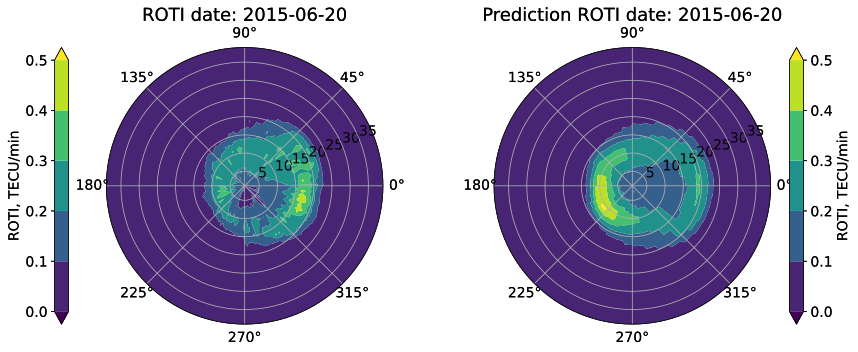

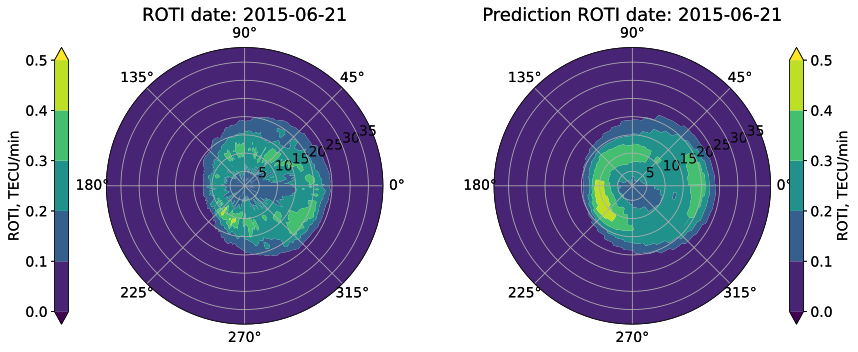

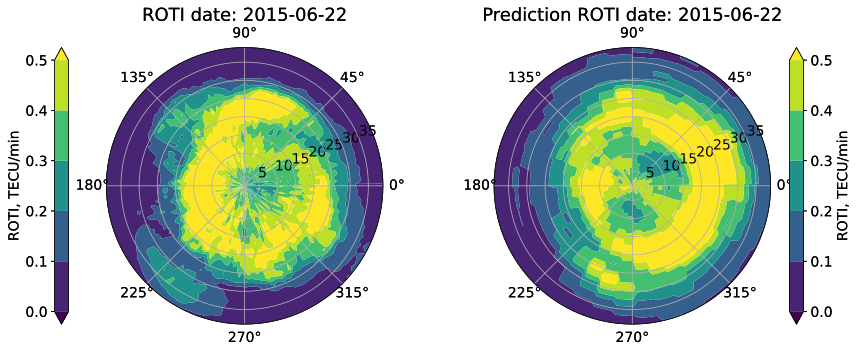

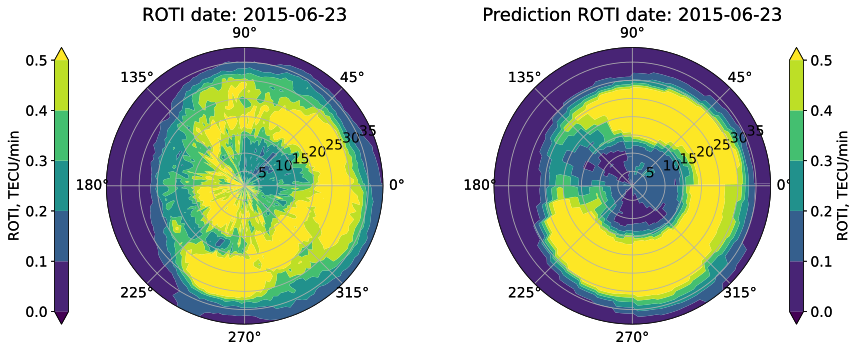

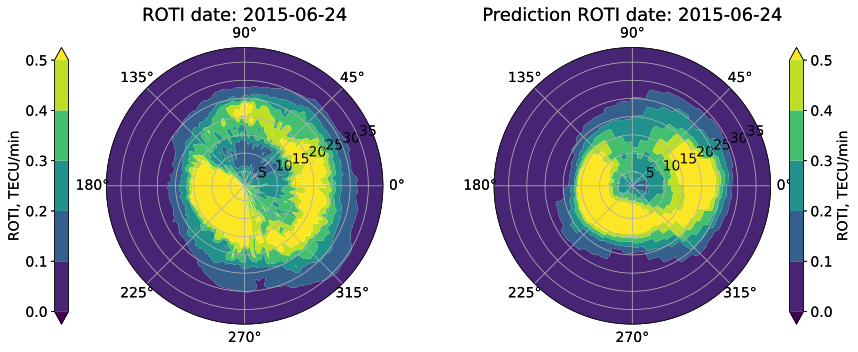

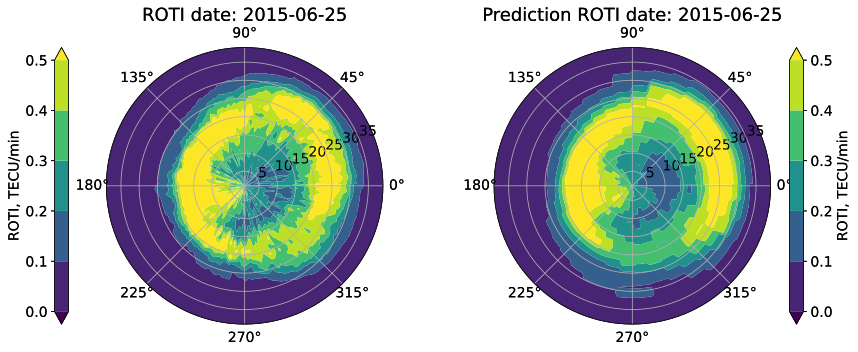

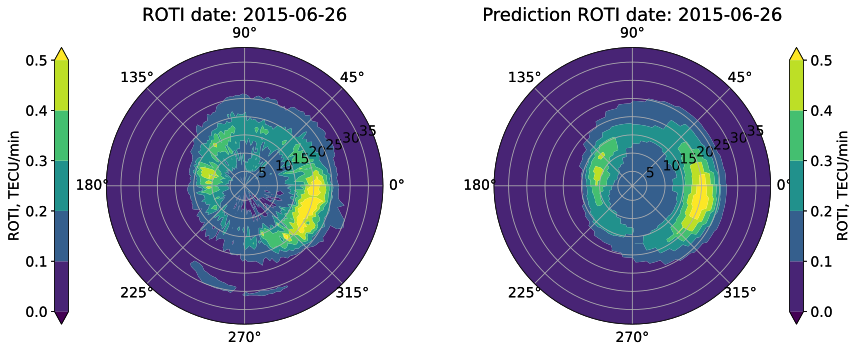

In [35]:
start = 1994
end = 2001

# start = 4455
# end = 4461

y_pred=classifier.predict(x_train_test[start:end])

print(y_pred.shape)
map_mean = []
pred_mean = []

for i in range(start, end, 1):
    # doy = str(day2doy(roti_map_date[i]) + x_train.shape[-1] // 6)
    doy = str(day2doy(roti_map_date[i]) + x_train_test.shape[1])
    year = str(roti_map_date[i][2] - 2000)
    if len(doy) == 1:
        filename = '../data/roti/2010-2020/roti' + '00' + doy + '0.' + year + 'f'
    elif len(doy) == 2:
        filename = '../data/roti/2010-2020/roti' + '0' + doy + '0.' + year + 'f'
    else:
        filename = '../data/roti/2010-2020/roti' + doy + '0.' + year + 'f'
    lats = []
    rows = []
    date_map = []
    all_maps = []

    pred_map = []
    for j in range(y_pred.shape[-1]):
        pred_map.append(y_pred[i - start][j])
    pred_map = np.array(pred_map)
    pred_map = pred_map.reshape(1, pred_map.shape[-1])

    # date, lats, date_map, map = read_roti(filename)
    try:
        date, lats, date_map, map = read_roti(filename)
    except FileNotFoundError:
        continue
    else:
        date, lats, date_map, map = read_roti(filename)

    all_maps.append(map)
    all_map = np.mean(all_maps, axis=0)
    lons = np.linspace(1, 361, all_map.shape[1])
    pred_map = roti_decode(pred_map, less_num=5)
    pred_map = pred_map.reshape(20, 180)
    plot_roti_near(date, lons, lats, map, pred_map)